# Agent 3: ReAct AI Agent

In [2]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  

from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM

from langchain_groq import ChatGroq
from langchain_core.tools import tool

from langgraph.graph.message import add_messages # Adds reducer functions (to prevent messages overwriting each other)
from langgraph.graph import StateGraph, END

from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [ ]:
class AgentState(TypedDict):
    """
    msg: Annotated[Sequence[BaseMessage], add_messages]
    
    Type Breakdown:
    - Sequence[BaseMessage]:
        An ordered collection of BaseMessage objects (e.g., HumanMessage,
        AIMessage, SystemMessage). Represents the conversation history.

    - Annotated[..., add_messages]:
        Adds metadata to the type hint. The `add_messages` function is used
        by the framework (e.g., LangGraph) as a reducer/merge strategy.
        Instead of replacing the message list during updates, new messages
        are appended using the add_messages logic.

    Overall Meaning:
        `msg` stores conversation messages, and updates to this field
        will append messages rather than overwrite them.
    """
    msg: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool


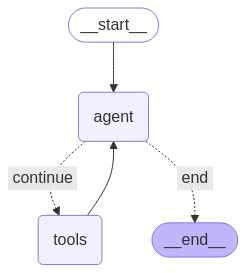